In [12]:
# pip install networkx==2.8.8
# pip install matplotlib == 3.2.2

In [13]:
import networkx as nx
import dgl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

* session: 1~13
* round數量不一定

In [14]:
feature_df = pd.read_csv('data/graph_feature.csv')
structure_df = pd.read_csv('data/graph_structure.csv')

In [15]:
structure_df

,session,uid,round,size,linked
0,1,1,1,15,"2,3,4,13,14,15"
1,1,2,1,15,"1,3,4,5,14,15"
2,1,3,1,15,"1,2,4,5,6,15"
3,1,4,1,15,"1,2,3,5,6,7"
4,1,5,1,15,"2,3,4,6,7,8"
...,...,...,...,...,...
2148,13,16,6,20,"13, 14, 15, 17, 18, 8, 19"
2149,13,17,6,20,"14, 15, 16, 18, 19, 4, 6"
2150,13,18,6,20,"1, 15, 16, 17, 19, 20, 7, 5, 11"
2151,13,19,6,20,"2, 17, 18, 4, 16, 5, 6"


In [16]:
structure_df[structure_df['session'] == 2]

,session,uid,round,size,linked
75,2,1,1,21,"2,3,4,19,20,21"
76,2,2,1,21,"1,3,4,5,20,21"
77,2,3,1,21,"1,2,4,5,6,21"
78,2,4,1,21,"1,2,3,5,6,7"
79,2,5,1,21,"2,3,4,6,7,8"
...,...,...,...,...,...
385,2,17,15,21,"14,15,16,20,18"
386,2,18,15,21,"16,17,9,8,19,21"
387,2,19,15,21,"16,18,2,15,20"
388,2,20,15,21,"19,8,21,4,12,16,11,17,9"


In [17]:
structure_df[structure_df['uid'] == 1].iloc[0]['linked'].split(',')

['2', '3', '4', '13', '14', '15']

用structure建立graph

In [18]:
session_size_dict = {}
for i in structure_df.drop_duplicates('session')[['session', 'size']].iloc:
    session_size_dict[i[0]] = i[1]

In [25]:
def create_graph(session, df):  # df size = graph size
    size = len(df)
    
    G = nx.Graph()
    nodes = range(1, size)
    G.add_nodes_from(nodes)
    for uid in range(1, size+1):
        neighbor_list = structure_df[structure_df['uid'] == uid].iloc[0]['linked'].split(',')
        edge_list = [(uid, neighbor) for neighbor in neighbor_list]
        G.add_edges_from(edge_list)
    return G

In [26]:
test_df = structure_df[structure_df['session'] == 1]
test_df = test_df[test_df['round'] == 1]

graph = create_graph(1, test_df)

In [27]:
def show_graph(nx_g):
    nx.draw(nx_g, with_labels=True)
    plt.show()

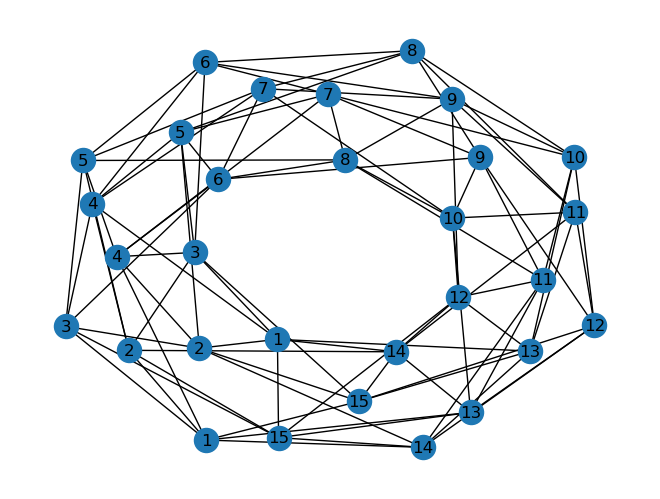

In [28]:
show_graph(graph)